In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plot_utils import plotCategoricalPerformance
from efn_util import get_flowdict, get_flowstring
import os
import seaborn as sns
import pandas as pd
from families import family_from_str
from plot_util import load_dim_sweep, dim_sweep_df

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)


In [2]:
exp_fam = 'dirichlet';

datadir = '/Users/sbittner/Documents/efn/results/Fig3/';
max_iters = 50000;
if (exp_fam == 'dirichlet'):
    Ds = [3, 5, 10, 15, 20, 25, 50];
    give_inverse_hint = False;
    scatterR2ylim = [.8, 1];
    errovbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 0.5];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'normal' or exp_fam == 'normal5'):
    Ds = [2, 5, 10, 15, 20, 25, 40];
    give_inverse_hint = True;
    scatterR2ylim = [.8, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, .5];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'inv_wishart'):
    Ds = [4, 9, 16];
    give_inverse_hint = True;
    scatterR2ylim = [0, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 10];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'prp_tn'):
    Ds = [2, 5, 10, 15, 20];
    give_inverse_hint = True;
    scatterR2ylim = [0, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 10];
    errorbarKLylim = scatterKLylim;
elif (exp_fam == 'dir_dir'):
    Ds = [5, 10, 15, 20];
    give_inverse_hint = True;
    scatterR2ylim = [0, 1];
    errorbarR2ylim = scatterR2ylim;
    scatterKLylim = [0, 10];
    errorbarKLylim = scatterKLylim;
    
num_Ds = len(Ds);
        
num_rs = 10;
K = 100;
M = 1000;

diagnostic_list = [];

EFN_elbos, EFN_R2s, EFN_KLs = load_dim_sweep(exp_fam, 'EFN', datadir, Ds, K, M, give_inverse_hint, max_iters);
diagnostic_list.append([EFN_elbos, EFN_R2s, EFN_KLs]);

NF1_elbos, NF1_R2s, NF1_KLs = load_dim_sweep(exp_fam, 'NF1', datadir, Ds, K, M, give_inverse_hint, max_iters, 10);
diagnostic_list.append([NF1_elbos, NF1_R2s, NF1_KLs]);

EFN1_elbos, EFN1_R2s, EFN1_KLs = load_dim_sweep(exp_fam, 'EFN1', datadir, Ds, K, M, give_inverse_hint, max_iters, 10);
diagnostic_list.append([EFN1_elbos, EFN1_R2s, EFN1_KLs]);


/Users/sbittner/Documents/efn/results/Fig3/EFN1/EFN_dirichlet_fixedEta_D=50_K=1_M=1000_flow=50P_L=7_rs=1/results.npz
looking back in time for latest R2 or KL
found it at 26100
/Users/sbittner/Documents/efn/results/Fig3/EFN1/EFN_dirichlet_fixedEta_D=50_K=1_M=1000_flow=50P_L=7_rs=6/results.npz
looking back in time for latest R2 or KL
found it at 26100
/Users/sbittner/Documents/efn/results/Fig3/EFN1/EFN_dirichlet_fixedEta_D=50_K=1_M=1000_flow=50P_L=7_rs=9/results.npz
looking back in time for latest R2 or KL
found it at 26200


/Users/sbittner/Documents/efn/util/plot_util.py:159: RuntimeWarning: invalid value encountered in less
  R2_isnegative = R2s_vec < 0;
/Users/sbittner/Library/Python/3.6/lib/python/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


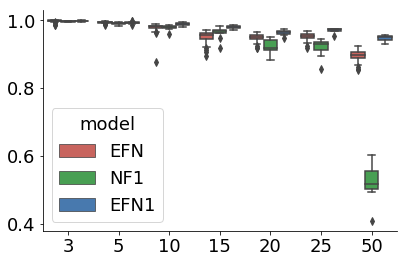

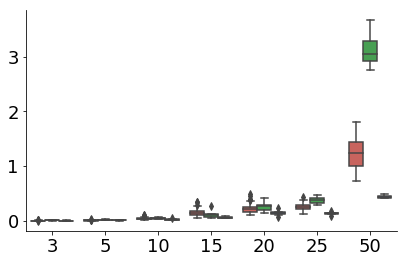

In [3]:
colors = ["pale red", "medium green", "windows blue", "amber", "dusty purple", "greyish", "faded green", "denim blue"];
palette = sns.xkcd_palette(colors)

df = dim_sweep_df(Ds, ['EFN', 'NF1', 'EFN1'], diagnostic_list);

plt.figure(figsize=(6,4));
ax = sns.boxplot(x='D', y='R2', hue='model', \
                      data=df, palette=palette)
if (not (exp_fam == 'dirichlet')):
    ax.legend_.remove();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig3/%s_R2.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();

plt.figure(figsize=(6,4));
ax = sns.boxplot(x='D', y='KL', hue='model',
                      data=df, palette=palette)
ax.legend_.remove()
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig3/%s_KL.pdf' % exp_fam, \
            dpi=300, transparent=True)
plt.show();